# Focusing via match filtering

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import sys, os
sys.path.append("../../src")
from surface import *
from source import *
from simulator import *
from focus import *

## Simulate to generate radargrams

In [2]:
# generate surface
surf = Surface(origin=(4500, 4500), dims=(400, 400), fs=5, overlap=0)
surf.gen_flat(0)

# generate sources
f0  = 9e6             # center frequency [Hz]
dt  = 1 / (8 * f0)    # time delta to avoid aliasing [s]
n = 1000
# source list
ss = []
for x in np.linspace(-10e3, 20e3, n):
    source = Source(dt, 0.5e-6, (x, 5050, 25000))
    source.chirp(f0, 1e6)
    ss.append(source)

# simulate over sources
rdrgrm, sltrng, phase_hist = run_sim_ms(surf, ss, (5000, 5000, -1000), reflect=False, phase=True, polarization="h")

In [3]:
sltrng = np.array(sltrng)
phase_hist = np.array(phase_hist)

## Where to focus and with what parameters?

In [4]:
c        = 299792458 # speed of light [m/s]
f_y, y_x = 959, 50   # what pixel to focus? (range bin, trace)
lam      = 33.3      # wavelength [m]
rng_st   = 20e3      # starting range [m]
rng_en   = 50e3      # ending range [m]
rng_res  = 300       # range resolution [m]
sampl    = 48e6      # sampling rate [Hz]
dt       = 1 / sampl # time interval [s]
dt_m     = dt * c    # space interval [m]

# how many range bins?
rb = int(((rng_en - rng_st) / c) / (1 / sampl))

In [5]:
# turn the slant range into range bin #
slant_rb = ((sltrng - rng_st) // dt_m).astype(int)

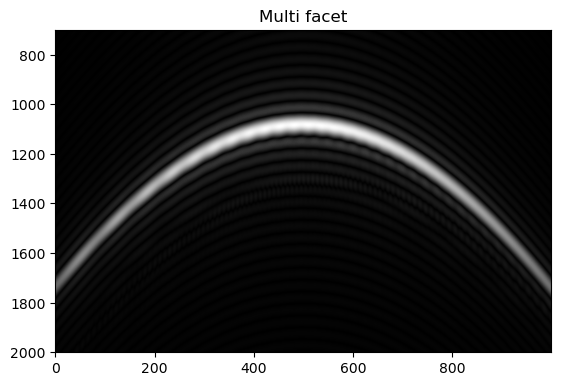

In [6]:
plt.imshow(np.abs(rdrgrm), aspect=5e-1, cmap="grey")
#plt.plot(range(len(slant_rb)), slant_rb, color="red", linewidth=1)
plt.title("Multi facet")
plt.ylim(2000, 700)
plt.show()

## Get values along hyperbola

In [7]:
hyper_val = rdrgrm[slant_rb, range(len(slant_rb))]

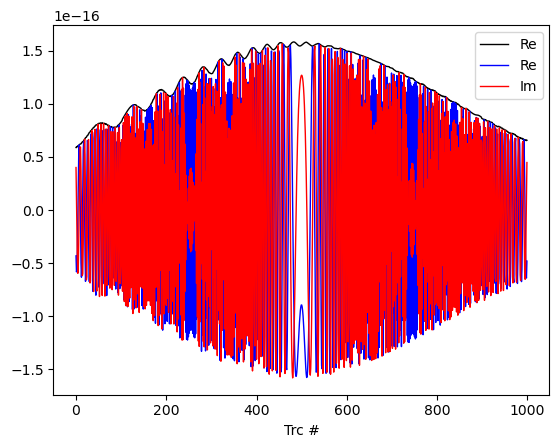

In [8]:
plt.plot(np.abs(hyper_val), color="black", linewidth=1, label="Re")
plt.plot(np.real(hyper_val), color="blue", linewidth=1, label="Re")
plt.plot(np.imag(hyper_val), color="red", linewidth=1, label="Im")
plt.legend()
plt.xlabel("Trc #")
plt.show()

## Attempt to reconstruct phase history from slant range

In [9]:
phase_hist_anl = ((2 * np.pi) / lam) * sltrng
if np.sum(phase_hist_anl - phase_hist) == 0:
    print(f"Successfully reconstructed phase history from slant range")

Successfully reconstructed phase history from slant range


## Reconstruct entire waveform and compare to sim

In [10]:
signals = []
for sr, ph in zip(sltrng, phase_hist):
    ssl = np.linspace(rng_st, rng_en, rb)
    delta_r = (ssl - sr) / rng_res
    signals.append(np.sinc(delta_r) * np.exp(2j * ph))
signals = np.array(signals).T

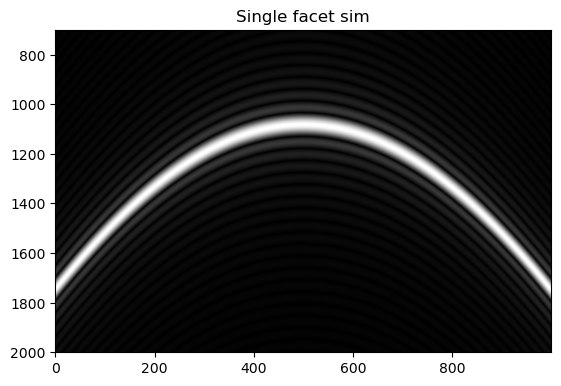

In [11]:
plt.imshow(np.abs(signals), cmap="grey", aspect=5e-1)
plt.ylim(2000, 700)
plt.title("Single facet sim")
plt.show()

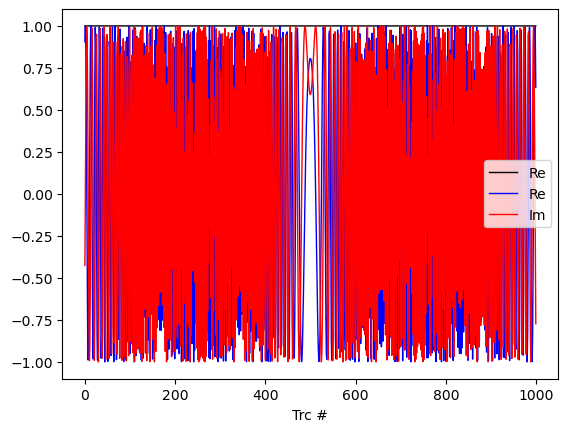

In [12]:
hyper_val = signals[slant_rb, range(len(slant_rb))]
plt.plot(np.abs(hyper_val), color="black", linewidth=1, label="Re")
plt.plot(np.real(hyper_val), color="blue", linewidth=1, label="Re")
plt.plot(np.imag(hyper_val), color="red", linewidth=1, label="Im")
plt.legend()
plt.xlabel("Trc #")
plt.show()

## Compare matched filters

**FROM SIM**

In [13]:
max_rb = np.argmax(np.abs(rdrgrm), axis=0)
match_filter_num = np.conjugate(rdrgrm[max_rb, range(n)])
match_filter_num_norm = match_filter_num / np.max(match_filter_num)

**ANALYTIC**

In [14]:
k = (2 * np.pi) / lam
match_filter_anl = np.exp(-2j * k * sltrng)
match_filter_anl_norm = match_filter_anl / np.max(match_filter_anl)

## Apply analytic matched filter

In [15]:
single_facet_focused = focus_jit(signals, slant_rb, match_filter_anl, 4803)

In [16]:
multi_facet_focused = focus_jit(rdrgrm, slant_rb, match_filter_anl, 4803)

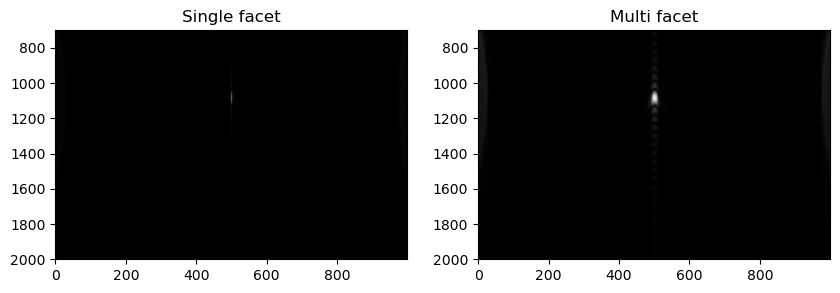

In [17]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].imshow(np.abs(single_facet_focused), cmap="grey", aspect=5e-1)
ax[0].set_title("Single facet")
ax[1].imshow(np.abs(multi_facet_focused), cmap="grey", aspect=5e-1)
ax[1].set_title("Multi facet")
for a in ax: a.set_ylim(2000, 700)
plt.show()

In [18]:
np.save("rdrgrm.npy", rdrgrm)
np.save("sltrng.npy", sltrng)